# 3.1 MULTILAYER PERCEPTRON MODEL

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import time, sys, json

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import mean_squared_error
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


# from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

# # If you use a GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

import seaborn as sns
import matplotlib.pyplot as plt


### 0) FUNCTIONS USED

In [3]:
# Split the sequence into samples
def split_sequences(sequences, n_steps): # Sequences is the dataset as 2d (X and Y) and n_steps the window for predicting next value
    ''' Split the sequence into samples'''
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Custom loss function to penalize scores outside (0,1)
def custom_loss(y_true, y_pred):
    '''Custom loss function to penalize scores outside [0,1]'''
    mse = mean_squared_error(y_true, y_pred)

    # Calculate Root Mean Squared Error (RMSE), same units as our data
    rmse = tf.sqrt(mse)

    # Apply a penalty if values are outside the desired range (0, 1)
    lower_bound_penalty = tf.maximum(0.0, y_pred - 1.0)
    upper_bound_penalty = tf.maximum(0.0, -y_pred)

    penalty_factor = 100.0

    total_loss = rmse + penalty_factor * (lower_bound_penalty + upper_bound_penalty)

    return total_loss

def reshape_sequence(sequence):
    """Reshape an array to have it in one column
    and the number of rows of its length (time series)"""
    return sequence.reshape((len(sequence), 1))

def get_additional_features(patient_data):
    """Extract additional features that are not variable for a patient."""
    preescolar = patient_data['age_Preescolar(0-5)'].iloc[0]
    children = patient_data['age_Children(6-11)'].iloc[0]
    teenager = patient_data['age_Teenagers(12-18)'].iloc[0]
    young_adult = patient_data['age_Young Adults(19-34)'].iloc[0]
    middle_adult = patient_data['age_Middle-Aged Adults(35-64)'].iloc[0]
    senior_adult = patient_data['age_Senior Adults(>65)'].iloc[0]
    gender = patient_data['gender'].iloc[0]

    return np.array([[gender, preescolar, children, teenager, young_adult, middle_adult, senior_adult]] * len(patient_data))

def create_and_compile_model(params, n_input):
    model = Sequential()

    # Loop to add the specified number of hidden layers
    for _ in range(params['num_layers']):
        # Add a hidden layer with the specified parameters
        model.add(Dense(30,
                        activation=params['activation'],
                        ))

        # Add dropout if specified
        if params['dropout_rate'] > 0:
            model.add(Dropout(params['dropout_rate']))

    # Add the output layer
    model.add(Dense(1))

    #optimizer
    optimizer = Adam(learning_rate=params['learning_rate'])

    # Compile the model with the selected optimizer and loss function
    model.compile(optimizer=optimizer, loss=custom_loss)

    return model

def print_progress_bar(iteration, total, bar_length=50):
    percent = "{0:.1f}".format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write(f"\rProgress: |{bar}| {percent}% Complete")
    sys.stdout.flush()

def js_r(json_file):
    with open(json_file) as json_file:
        dict_file = json.load(json_file)
    return dict_file


### 1) TIME SERIES DATA PREPARATION FOR MLP MODEL

##### We have a **multivariate** (more than one feature) **multistep** (we want to predict more than one day) **non-parallel** (just predict one output variable) structure. To prepare our data, we need to:

- Transform the time series dataset into a two-dimensional supervised learning format
- Transform the two-dimensional data into a three-dimensional structure for CNN and LSTM

In [42]:
series = pd.read_csv("data/model_data01.csv")
series.head()

,patient_id,week,score,gender,Attention,Executive Functions,Gnosis,Language,Memory,Visuospatial Skills,age_Preescolar(0-5),age_Children(6-11),age_Teenagers(12-18),age_Young Adults(19-34),age_Middle-Aged Adults(35-64),age_Senior Adults(>65),age_group,combined_target
0,5e3175d5,01-2016,0.5833,2,0.584338,0.583300,0.458823,0.590329,0.629467,0.380805,0,0,0,0,1,0,5,2_5
1,5e3175d5,01-2021,0.3310,2,0.331078,0.331000,0.519627,0.331000,0.228763,0.372512,0,0,0,0,1,0,5,2_5
2,5e3175d5,02-2017,0.9820,2,0.982000,0.783395,0.648470,0.790198,0.824775,0.411100,0,0,0,0,1,0,5,2_5
3,5e3175d5,02-2019,0.3875,2,0.386652,0.387500,0.469652,0.381261,0.175828,0.377389,0,0,0,0,1,0,5,2_5
4,5e3175d5,02-2020,0.5282,2,0.528377,0.528200,0.479586,0.528200,0.547278,0.387961,0,0,0,0,1,0,5,2_5


In [43]:
len(series['patient_id'].unique())

1813

We divided our dataset into 8 stratified datasets for age group and gender. We will use each of them and at the end compare the optimal hyperparameters combination. The n_steps determines the window size used as we reshape the data into X (predictive variables) and Y (score) arrays:

In [45]:
unique_patients = series['patient_id'].unique()
patient_datasets = {}
n_steps = 2  # window size

for patient_id in unique_patients:
    patient_data = series[series['patient_id'] == patient_id]

    additional_features = get_additional_features(patient_data)
    
    sequences = [
        'Attention', 'Executive Functions', 'Gnosis', 
        'Language', 'Memory', 'Visuospatial Skills']

    in_sequences = [reshape_sequence(patient_data[seq].values) for seq in sequences]

    out_seq = reshape_sequence(patient_data['score'].values)

    if len(in_sequences[0]) >= n_steps:  # Assuming all sequences have the same length
        # Combine all sequences along with additional features
        combined_data = np.hstack((additional_features, *in_sequences, out_seq))

        # Split time series into samples
        X, y = split_sequences(combined_data, n_steps)

        # Convert to float
        X = X.astype(float)
        y = y.astype(float)

        # Flatten input samples (ONLY FOR MLP MODEL)
        n_input = X.shape[1] * X.shape[2]
        X = X.reshape((X.shape[0], n_input))

        # Save data for each patient
        patient_datasets[patient_id] = {'X': X, 'y': y}

In [47]:
# Example of patient first time point
patient_datasets['00531858']['X'][0]

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.2704    , 0.3061    , 0.50545191,
       0.2357    , 0.56123198, 0.22016896, 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.47896667, 0.46616667, 0.43355   , 0.2817    , 0.73333333,
       0.0138    ])

### 2) TIME SERIES CROSS VALIDATION AND GRID SEARCH TO FIND THE BEST HYPERPARAMETERS

In [48]:
# Define the hyperparameter grid
param_grid = {
    'num_layers': [1, 2, 3], # Number of neuron layers
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate for the optimizer
    'activation': ['relu', 'selu', 'tanh'],   # Activation function for hidden layers
    'dropout_rate': [0, 0.05, 0.1],  # Dropout rate to use, if any (regularization technique)
}

grid = ParameterGrid(param_grid)

n_splits = 2

# cross validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Create a dictionary to store average loss for each parameter combination
val_loss_by_patient = {}

# Store models
params_dict = {}

#  Trying with 100 patients
chunk0 = unique_patients[:100]
# chunk1 = unique_patients[:311]
# chunk2 = unique_patients[311:622]
# chunk3 = unique_patients[622:933]
# chunk4 = unique_patients[933:1244]

# Track progress
total_iterations = len(chunk0)
total_total_iterations = len(grid) * len(chunk0)
iteration_count = 0
start_time = time.time()

In [49]:
print("STARTING HYPERPARAMETER TUNING: \n")
for model_number,params in enumerate(grid):
    print(f"\n\nModel {model_number+1} / {len(grid)} training\n")
    params_dict [model_number +1] = str(params)
    model = create_and_compile_model(params, n_input)

    for index, patient_id in enumerate(chunk0, start=1):
        sys.stdout.write("\r")  # Move cursor to the beginning of the line
        sys.stdout.write(f"STARTING CHUNK {index} / {total_iterations}")
        sys.stdout.flush()

        data = patient_datasets[patient_id]
        X, y = data['X'], data['y']

        # Split data
        split_index1 = int(0.6 * len(X))
        split_index2 = int(0.8 * len(X))
        X_train, X_val, _ = X[:split_index1], X[split_index1:split_index2], X[split_index2:]
        y_train, y_val, _ = y[:split_index1], y[split_index1:split_index2], y[split_index2:]

        val_loss_list = [] # List to store validation loss

        try:
          for train_index, val_index in tscv.split(X_train):
              X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
              y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

              # Train model
              model.fit(X_train_fold, y_train_fold,epochs=40, verbose=0)

              # Evaluate on validation set
              val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
              val_loss_list.append(val_loss)

        except ValueError:
          # Handle patients where Time SeriesSplit cannot be performed
          continue
          # print(f"\nSkipping patient {patient_id} due to insufficient data for TimeSeriesSplit")

        if len(val_loss_list) != 0:
          val_loss_by_patient[(model_number +1, patient_id)] = val_loss_list

        iteration_count += 1
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / iteration_count if iteration_count > 0 else 0
        remaining_iterations = total_iterations - iteration_count
        estimated_remaining_time = remaining_iterations * avg_time_per_iteration
        print_progress_bar(iteration_count, total_total_iterations)

print("\n")
print("HYPERPARAMETER TUNING DONE")
print("\nSaving loss and model dictionaries...")

# Convert tuple keys to strings
val_loss_by_patient_str_keys = {str(key): value for key, value in val_loss_by_patient.items()}

# # Save dictionary as a JSON file
# with open('data/MLP/MLP_val_loss_models.json', 'w') as f:
#     json.dump(val_loss_by_patient_str_keys, f)

# with open('data/MLP/MLP_models_dictionary.json', 'w') as f:
#     json.dump(params_dict, f)

print("DONE, CHUNK FINISHED")

STARTING HYPERPARAMETER TUNING: 



Model 1 / 81 training

Progress: |█-------------------------------------------------| 1.2% Complete

Model 2 / 81 training

Progress: |█-------------------------------------------------| 2.5% Complete

Model 3 / 81 training

Progress: |██------------------------------------------------| 3.7% Complete

Model 4 / 81 training

Progress: |██------------------------------------------------| 4.9% Complete

Model 5 / 81 training

Progress: |███-----------------------------------------------| 6.2% Complete

Model 6 / 81 training

Progress: |████----------------------------------------------| 7.4% Complete

Model 7 / 81 training

Progress: |████----------------------------------------------| 8.6% Complete

Model 8 / 81 training

Progress: |█████---------------------------------------------| 9.9% Complete

Model 9 / 81 training

Progress: |██████--------------------------------------------| 11.1% Complete

Model 10 / 81 training

Progress: |██████-------------

### 3) BEST HYPERPARAMETER CALCULATIONS FOR EACH SUBSET OF DATA

In [4]:
models_dict = js_r('data/MLP/MLP_models_dictionary.json')
# models_dict

# LOSS FOR EACH TIME SERIES SPLIT FOR EVERY PATIENT IN EVERY MODEL
patients_loss = js_r('data/MLP/MLP_val_loss_models.json')
# patients_loss

# Calculate the mean for each list of values and update the dictionary
for patient, values in patients_loss.items():
    mean_value = sum(values) / len(values)
    patients_loss[patient] = mean_value

# Initialize an empty DataFrame
loss_df = pd.DataFrame()

# Iterate through the dictionary and add columns to the DataFrame
for key, values in patients_loss.items():
    model_number, patient_id = eval(key)
    
    # Create a new column if it doesn't exist
    if f'model{model_number}' not in loss_df.columns:
        loss_df[f'model{model_number}'] = pd.Series(dtype=float)
    
    # Add the value to the corresponding column and row
    loss_df.at[patient_id, f'model{model_number}'] = values

# Reset the index to have 'patient_id' as a column
loss_df = loss_df.reset_index()
loss_df = loss_df.set_index('index')

#### 3.1) ACTIVATION FUNCTION

0.1131182756380077
5.2976923296491325
0.7855999485859106


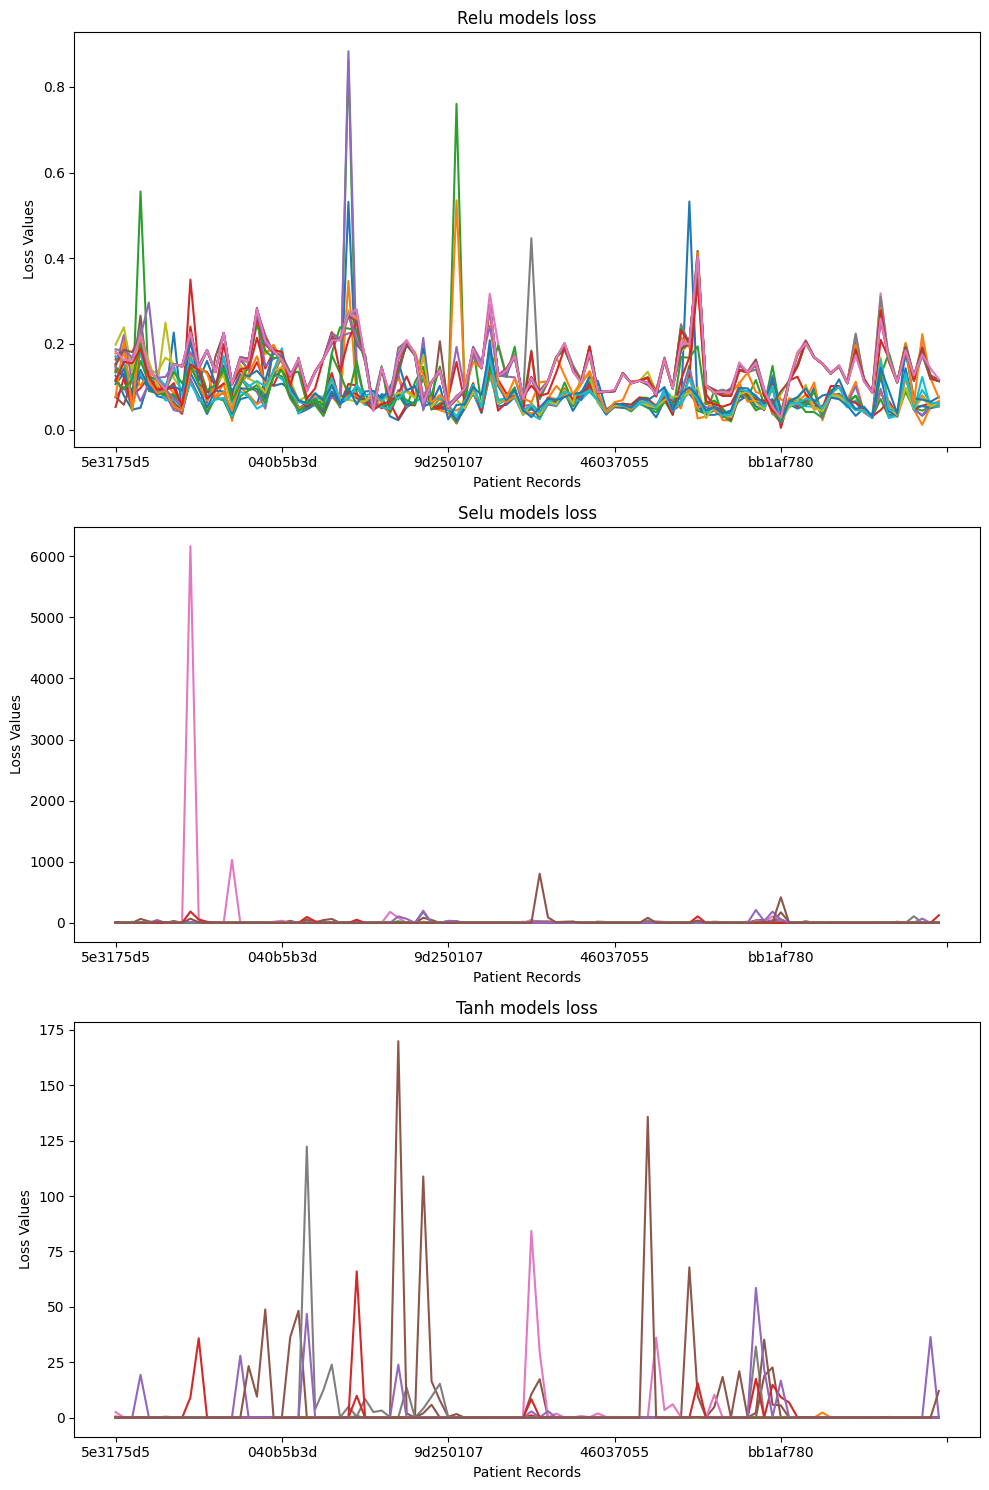

In [9]:
# Define the ranges for different activation functions
activation_ranges = [(0, 27), (28, 54), (55, 81)]
activation_names = ['Relu models loss', 'Selu models loss', 'Tanh models loss']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each activation range
for i, (start_idx, end_idx) in enumerate(activation_ranges):
    # Extract the relevant columns for the current activation range
    subset_df = loss_df.iloc[:, start_idx:end_idx]

    mean_val = subset_df.mean(axis=1).mean()
    print(mean_val)
    # if i == 1:
        # subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)
    
    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)
    
    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(activation_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
# for ax in axes:
#     ax.set_ylim(0, 5)

# axes[1].set_ylim(0,5)
# axes[2].set_ylim(0,5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

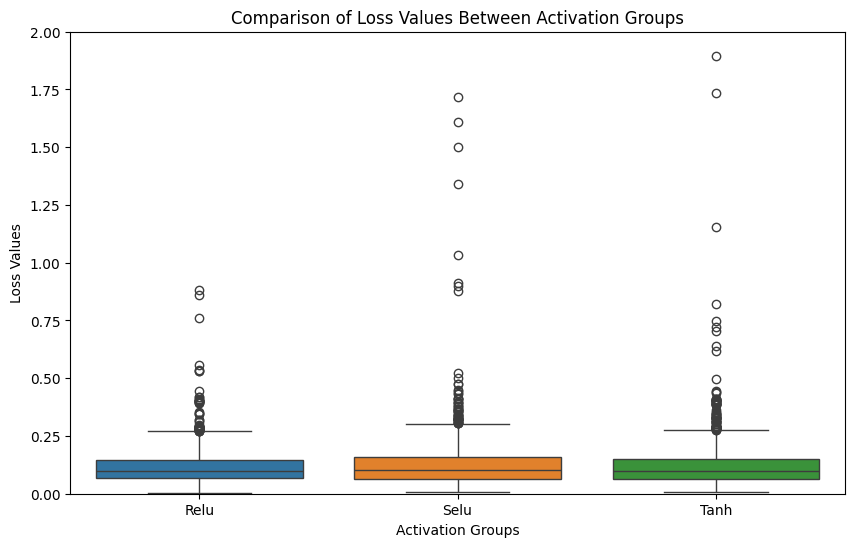

In [52]:
# Define the ranges for different activation functions
activation_ranges = [(0, 27), (28, 54), (55, 81)]
activation_names = ['Relu', 'Selu', 'Tanh']

# Create an empty list to store the data for each group
group_data = []

# Iterate through each activation range
for start_idx, end_idx in activation_ranges:
    # Extract the relevant columns for the current activation range
    subset_df = loss_df.iloc[:, start_idx:end_idx]

    # if i == 1:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)
        
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

plt.xticks(ticks=[0, 1, 2], labels=activation_names)

# Set a maximum value for the y-axis
plt.ylim(0, 2)  # Replace 'your_maximum_value' with the desired value

plt.xlabel('Activation Groups')
plt.ylabel('Loss Values')
plt.title('Comparison of Loss Values Between Activation Groups')

# Show the plot
plt.show()

#### 3.2) NUMBER OF LAYERS

In [53]:
i = 0
layer_range1 = []
layer_range2 = []
layer_range3 = []

while i < 80:
    layer_range1.append(i)
    layer_range2.append(i+1)
    layer_range3.append(i+2)
    i += 3

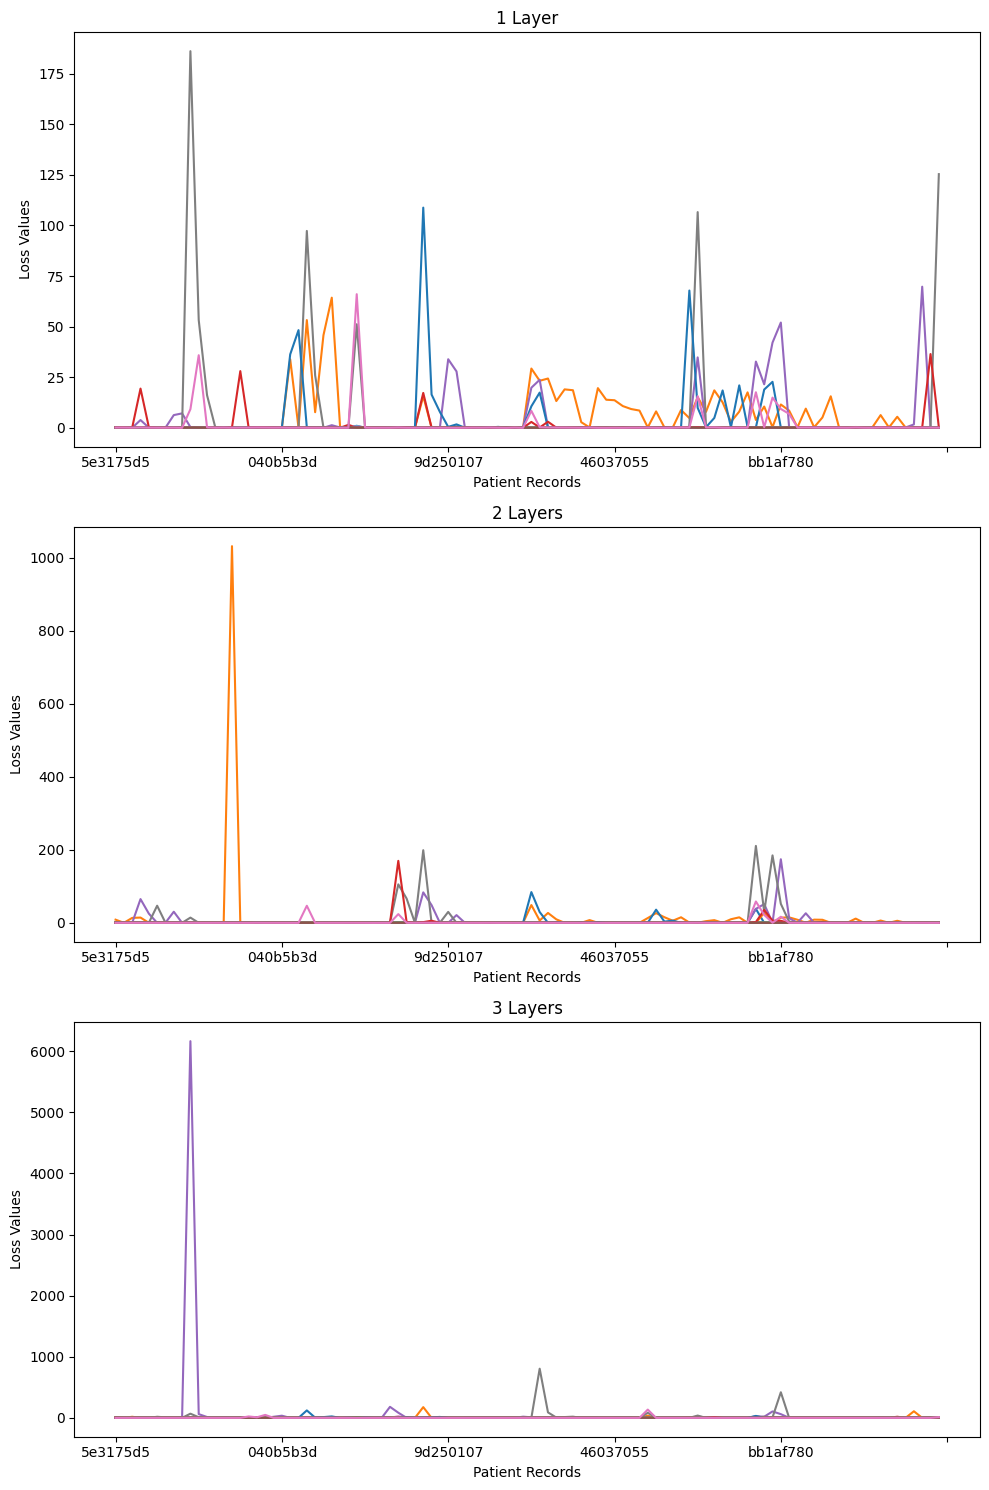

In [54]:
layer_ranges = [layer_range1, layer_range2, layer_range3]
layer_names = ['1 Layer', '2 Layers', '3 Layers']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each layer range
for i, indices in enumerate(layer_ranges):        
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop('model52', axis=1)
    # elif i == 1:
    #     subset_df = subset_df.drop('model35', axis=1)
    # else:
    #     subset_df = subset_df.drop(['model36', 'model54'], axis=1)

    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)

    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(layer_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
# for ax in axes:
#     ax.set_ylim(0, 20)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

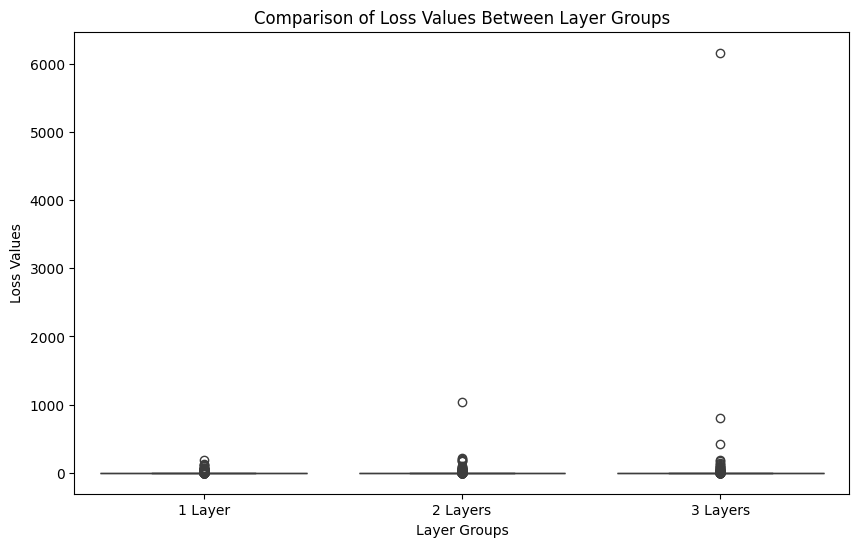

In [55]:
layer_ranges = [layer_range1, layer_range2, layer_range3]
layer_names = ['1 Layer', '2 Layers', '3 Layers']

# Create an empty list to store the data for each group
group_data = []

# Iterate through each layer range
for i, indices in enumerate(layer_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop('model52', axis=1)
    # elif i == 1:
    #     subset_df = subset_df.drop('model35', axis=1)
    # else:
    #     subset_df = subset_df.drop(['model36', 'model54'], axis=1)
    
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

# Set x-axis labels
plt.xticks(ticks=range(len(layer_names)), labels=layer_names)

# Max y value
# plt.ylim(0, 0.5)  

plt.xlabel('Layer Groups')
plt.ylabel('Loss Values')
plt.title('Comparison of Loss Values Between Layer Groups')

# Show the plot
plt.show()

#### 3.3) LEARNING RATE

In [56]:
i = 0
lr_range1 = []
lr_range2 = []
lr_range3 = []

while i < 78:
    lr_range1.extend([i, i+1, i+2])
    lr_range2.extend([i+3, i+4, i+5])
    lr_range3.extend([i+6, i+7, i+8])
    i += 9

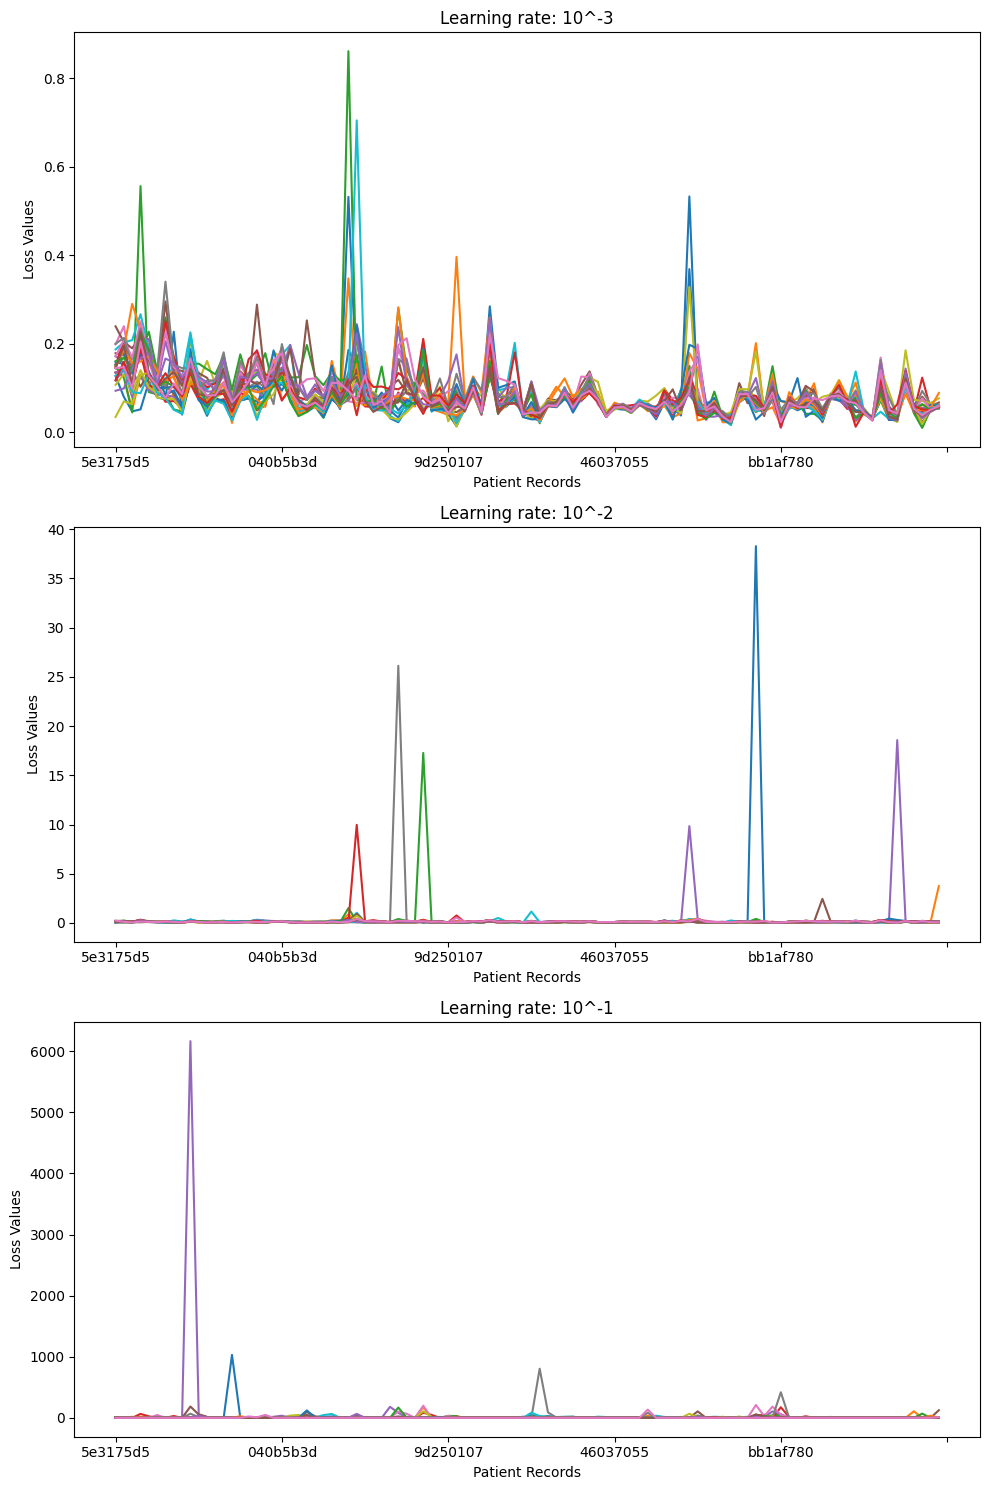

In [57]:
lr_ranges = [lr_range1, lr_range2, lr_range3]
lr_names = ['Learning rate: 10^-3', 'Learning rate: 10^-2', 'Learning rate: 10^-1']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each layer range
for i, indices in enumerate(lr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 2:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)

    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)

    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(lr_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
# for ax in axes:
#     ax.set_ylim(0, 10)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

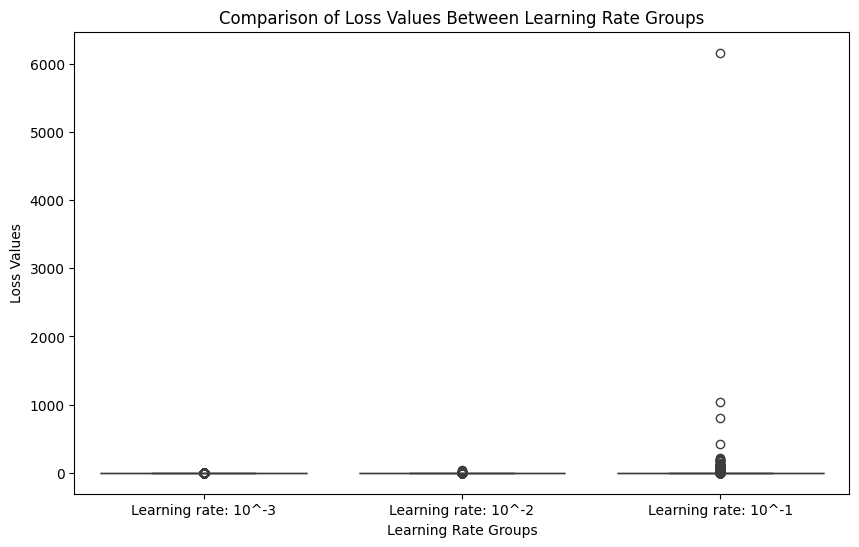

In [58]:
lr_ranges = [lr_range1, lr_range2, lr_range3]
lr_names = ['Learning rate: 10^-3', 'Learning rate: 10^-2', 'Learning rate: 10^-1']

# Create an empty list to store the data for each group
group_data = []

# Iterate through each lr range
for i, indices in enumerate(lr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 2:
    #     subset_df = subset_df.drop(['model35','model36','model52', 'model54'], axis=1)
    
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

# Set x-axis labels
plt.xticks(ticks=range(len(lr_names)), labels=lr_names)

# Max y value
# plt.ylim(0, 50)  

plt.xlabel('Learning Rate Groups')
plt.ylabel('Loss Values')
plt.title('Comparison of Loss Values Between Learning Rate Groups')

# Show the plot
plt.show()

#### 3.4) DROPOUT RATE

In [59]:
i = 0
dr_range1 = []
dr_range2 = []
dr_range3 = []

while i < 81:
    dr_range1.extend([i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8])
    dr_range2.extend([i+9, i+10, i+11, i+12, i+13, i+14, i+15, i+16, i+17])
    dr_range3.extend([i+18, i+19, i+20, i+21, i+22, i+23, i+24, i+25, i+26])
    i += 27

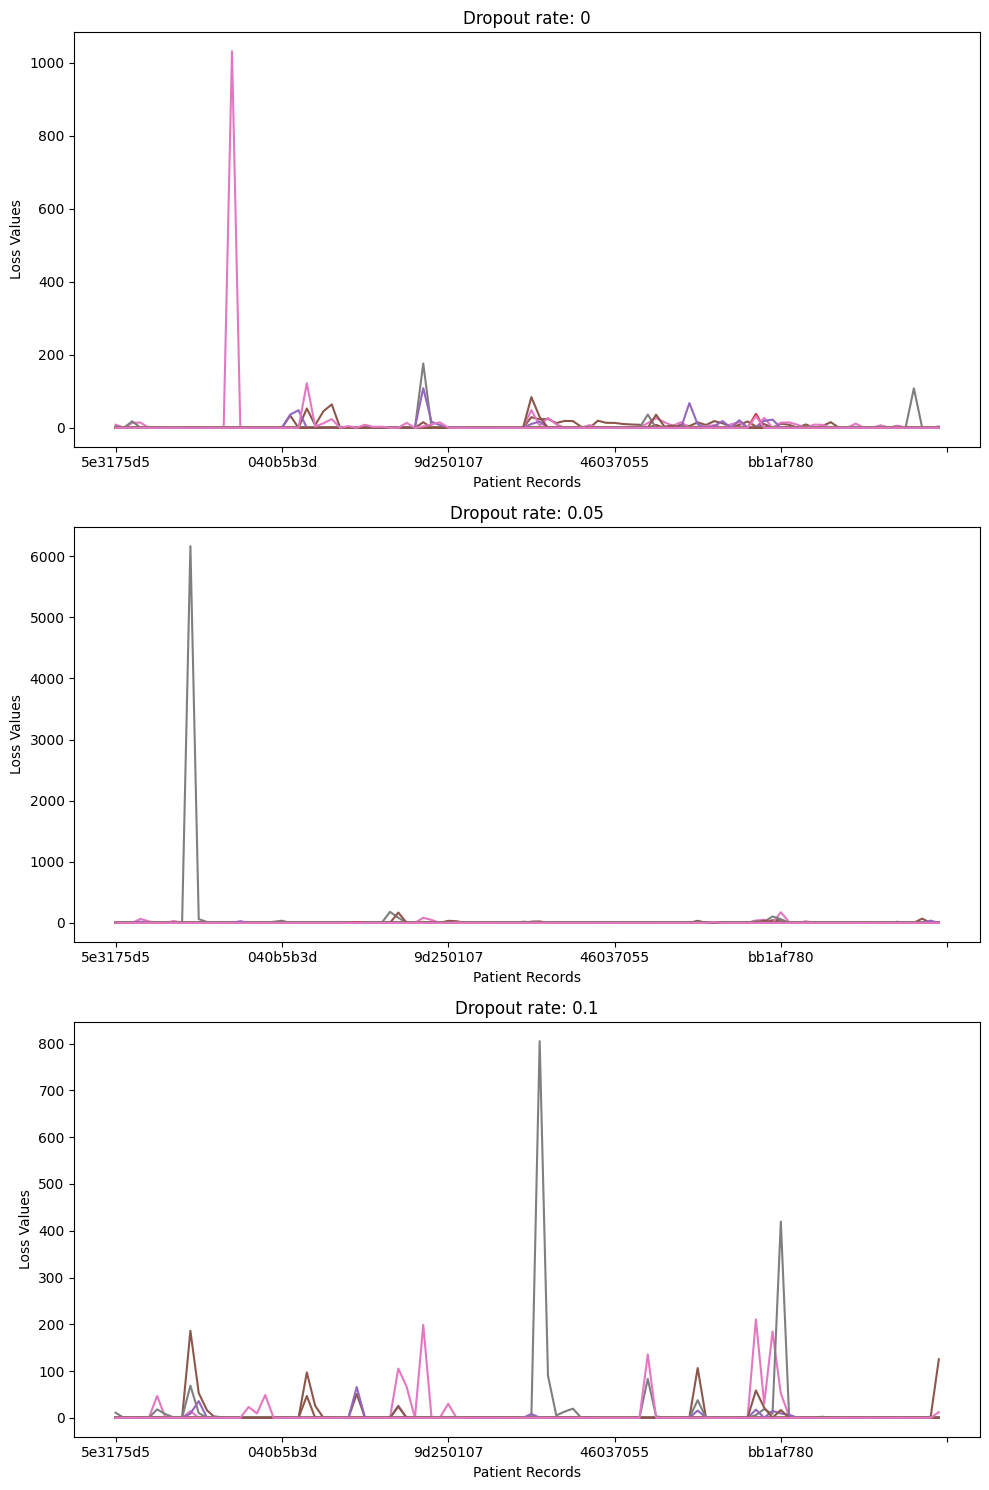

In [60]:
dr_ranges = [dr_range1, dr_range2, dr_range3]
dr_names = ['Dropout rate: 0', 'Dropout rate: 0.05', 'Dropout rate: 0.1']

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Iterate through each layer range
for i, indices in enumerate(dr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop(['model35','model36'], axis=1)
    # elif i == 2:
    #     subset_df = subset_df.drop(['model52','model54'], axis=1)

    # Plot the data on the current subplot
    subset_df.plot(ax=axes[i], legend=False)

    # Add labels and title
    axes[i].set_xlabel('Patient Records')
    axes[i].set_ylabel('Loss Values')
    axes[i].set_title(dr_names[i])

# Add legend to the last subplot
# axes[-1].legend(title='Model')

# # Maximum y value to make zoom into the plot
# for ax in axes:
#     ax.set_ylim(0, 0.5)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

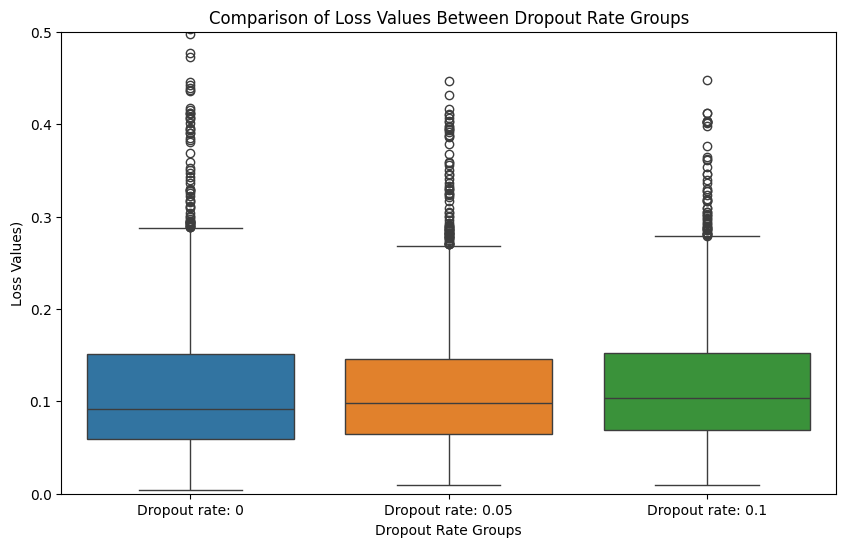

In [61]:
dr_ranges = [dr_range1, dr_range2, dr_range3]
dr_names = ['Dropout rate: 0', 'Dropout rate: 0.05', 'Dropout rate: 0.1']


# Create an empty list to store the data for each group
group_data = []

# Iterate through each lr range
for i, indices in enumerate(dr_ranges):
    # Validate indices against the number of columns
    valid_indices = [index for index in indices if index < len(loss_df.columns)]

    # Extract the relevant columns for the current layer range
    subset_df = loss_df.iloc[:, valid_indices]

    # if i == 0:
    #     subset_df = subset_df.drop(['model35','model36'], axis=1)
    # elif i == 2:
    #     subset_df = subset_df.drop(['model52','model54'], axis=1)
    
    # Flatten the subset_df to create a single column for each group
    subset_data = subset_df.values.flatten()
    
    # Append the data to the group_data list
    group_data.append(subset_data)

# Create a DataFrame from the group_data list
grouped_df = pd.DataFrame(group_data).transpose()

# Set up the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df)

# Set x-axis labels
plt.xticks(ticks=range(len(dr_names)), labels=dr_names)

# Max y value
plt.ylim(0, 0.5)  

plt.xlabel('Dropout Rate Groups')
plt.ylabel('Loss Values)')
plt.title('Comparison of Loss Values Between Dropout Rate Groups')

# Show the plot
plt.show()

- **Relu** activation function seems more constant, and doesn't have high outliers. 

- **Layers** with no difference, so we choose 1 for computational efficiency.

- **Learning rate** of 10^-3 seems more constant.

- **Dropout rate** with no important differences...

### 4) MODEL PREDICTIONS ON TEST SET

We do predictions on each of the evaluation datasets (2, 3 and 4). Generated dictionary files will be used for each of them.

In [22]:
series2 = pd.read_csv("data/model_data02.csv")
series2.head()

,patient_id,week,score,gender,Attention,Executive Functions,Gnosis,Language,Memory,Visuospatial Skills,age_Preescolar(0-5),age_Children(6-11),age_Teenagers(12-18),age_Young Adults(19-34),age_Middle-Aged Adults(35-64),age_Senior Adults(>65),age_group,combined_target
0,b13fd4a3,00-2018,0.2609,1,0.263250,0.260900,0.381300,0.262460,0.267238,0.326500,0,0,0,0,1,0,5,1_5
1,b13fd4a3,01-2017,0.3879,1,0.436600,0.192900,0.420490,0.189686,0.354349,0.484752,0,0,0,0,1,0,5,1_5
2,b13fd4a3,02-2016,0.9722,1,0.504862,0.972200,0.381300,0.974630,0.741500,0.326500,0,0,0,0,1,0,5,1_5
3,b13fd4a3,02-2017,0.3128,1,0.312800,0.453212,0.399528,0.318559,0.370146,0.311938,0,0,0,0,1,0,5,1_5
4,b13fd4a3,02-2018,0.5007,1,0.497261,0.500700,0.381300,0.500700,0.601340,0.326500,0,0,0,0,1,0,5,1_5


In [52]:
unique_patients = series2['patient_id'].unique()
# unique_patients = unique_patients[0:1000]

patient_datasets = {}
n_steps = 2  # window size

for patient_id in unique_patients:
    patient_data = series2[series2['patient_id'] == patient_id]

    additional_features = get_additional_features(patient_data)

    sequences = [
        'Attention', 'Executive Functions', 'Gnosis', 
        'Language', 'Memory', 'Visuospatial Skills']

    in_sequences = [reshape_sequence(patient_data[seq].values) for seq in sequences]

    out_seq = reshape_sequence(patient_data['score'].values)

    if len(in_sequences[0]) >= n_steps:  # Assuming all sequences have the same length
        # Combine all sequences along with additional features
        combined_data = np.hstack((additional_features, *in_sequences, out_seq))

        # Split time series into samples
        X, y = split_sequences(combined_data, n_steps)

        # Convert to float
        X = X.astype(float)
        y = y.astype(float)

        # Flatten input samples (ONLY FOR MLP MODEL)
        n_input = X.shape[1] * X.shape[2]
        X = X.reshape((X.shape[0], n_input))

        # Save data for each patient
        patient_datasets[patient_id] = {'X': X, 'y': y}

In [82]:
patient_datasets['3e0206e6']['X']

array([[2.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.40025   , 0.0794    , 0.2472    ,
        0.2714    , 0.1971    , 0.20293983, 2.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.1746    , 0.08049654, 0.1556    , 0.1858    , 0.1793    ,
        0.3295    ],
       [2.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.1746    , 0.08049654, 0.1556    ,
        0.1858    , 0.1793    , 0.3295    , 2.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.18405   , 0.0647    , 0.436     , 0.3214    , 0.16693176,
        0.12582994],
       [2.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.18405   , 0.0647    , 0.436     ,
        0.3214    , 0.16693176, 0.12582994, 2.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
      

In [53]:
# Error in one
unique_patients = np.delete(unique_patients, 1150)

In [54]:
# Define the hyperparameter grid
params = {
    'num_layers': [1], # Number of neuron layers
    'learning_rate': [0.001],  # Learning rate for the optimizer
    'activation': ['relu'],   # Activation function for hidden layers
    'dropout_rate': [0.05],  # Dropout rate to use, if any (regularization technique)
}

grid = ParameterGrid(params)

# chunk0 = unique_patients[:100]
# chunk1 = unique_patients[:311]
# chunk2 = unique_patients[311:622]
# chunk3 = unique_patients[622:933]
# chunk4 = unique_patients[933:1244]

# Track progress
total_iterations = len(unique_patients)
total_total_iterations = len(grid) * len(unique_patients)
iteration_count = 0
start_time = time.time()

In [56]:
# Saving test data
predictions_by_patient = {}

# Set a random seed for reproducibility
tf.random.set_seed(42)

model = Sequential()
# Add a hidden layer with the specified parameters
model.add(Dense(30, activation='relu',))
model.add(Dropout(0.05))
# Add the output layer
model.add(Dense(1))
#optimizer
optimizer = Adam(learning_rate=0.001)
# Compile the model with the selected optimizer and loss function
model.compile(optimizer=optimizer, loss=custom_loss)

for index, patient_id in enumerate(unique_patients, start=1):
    # sys.stdout.write("\r")  # Move cursor to the beginning of the line
    # sys.stdout.write(f"STARTING CHUNK EVALUATION IN PATIENT {index} / {len(unique_patients)} \n")
    # sys.stdout.flush()

    data = patient_datasets[patient_id]
    X, y = data['X'], data['y']

    # # Split data
    # split_index1 = int(0.7 * len(X))
    # X_train, X_test = X[:split_index1], X[split_index1:]
    # y_train, Y_test = y[:split_index1], y[split_index1:]

    # Ensure that there are at least 20 data points for training and 10 for testing
    if len(X) >= 30:
        # Extract the last 10 data points for the test set and the previous 20 for the training set
        X_train, y_train = X[-30:-10], y[-30:-10]
        X_test, y_test = X[-10:], y[-10:]
    
        # Train the model on patient-specific data
        model.fit(X_train, y_train, epochs=40, verbose=0)
    
        # Make predictions on the test set
        predictions = model.predict(X_test, verbose=0)
    else:
        iteration_count += 1
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / iteration_count if iteration_count > 0 else 0
        remaining_iterations = total_iterations - iteration_count
        estimated_remaining_time = remaining_iterations * avg_time_per_iteration
    
        # Create dynamic progress update string
        progress_update = f"PROGRESS: {iteration_count}/{total_iterations} - Elapsed Time: {elapsed_time:.2f}s - Estimated Remaining Time: {estimated_remaining_time:.2f}s"
    
        # Print dynamic progress update
        sys.stdout.write("\r" + " " * len(progress_update))  # Clear the previous line
        sys.stdout.write("\r" + progress_update)  # Print the dynamic progress update
        sys.stdout.flush()
        continue

     # Save predictions for later analysis
    predictions_by_patient[patient_id] = {'predictions': predictions, 'true_values': y_test}

    iteration_count += 1
    elapsed_time = time.time() - start_time
    avg_time_per_iteration = elapsed_time / iteration_count if iteration_count > 0 else 0
    remaining_iterations = total_iterations - iteration_count
    estimated_remaining_time = remaining_iterations * avg_time_per_iteration

    # Create dynamic progress update string
    progress_update = f"PROGRESS: {iteration_count}/{total_iterations} - Elapsed Time: {elapsed_time:.2f}s - Estimated Remaining Time: {estimated_remaining_time:.2f}s"

    # Print dynamic progress update
    sys.stdout.write("\r" + " " * len(progress_update))  # Clear the previous line
    sys.stdout.write("\r" + progress_update)  # Print the dynamic progress update
    sys.stdout.flush()

print("\n")
print("PREDICTION ON TEST SET DONE")

PROGRESS: 797/1812 - Elapsed Time: 463.13s - Estimated Remaining Time: 589.81ss

PREDICTION ON TEST SET DONE


In [63]:
predictions_by_patient

{'b13fd4a3': {'predictions': [0.49487876892089844,
   0.5096990466117859,
   0.3994806706905365,
   0.39800330996513367,
   0.39165154099464417,
   0.4940854012966156,
   0.5318767428398132,
   0.42355164885520935,
   0.380771666765213,
   0.3795352578163147],
  'true_values': [0.4821,
   0.3302,
   0.3143,
   0.25,
   0.4372,
   0.536,
   0.2948,
   0.3333,
   0.1634,
   0.5467]},
 '2cccfdd5': {'predictions': [0.6560112237930298,
   0.57996666431427,
   0.5103174448013306,
   0.49382027983665466,
   0.6661717295646667,
   0.6712252497673035,
   0.3546278774738312,
   0.4455779492855072,
   0.6961520910263062,
   0.49527880549430847],
  'true_values': [0.667,
   0.577,
   0.3958,
   0.487,
   0.952,
   0.4571,
   0.2467,
   0.9829,
   0.88,
   0.1343]},
 'e05868f8': {'predictions': [0.3361804783344269,
   0.281887412071228,
   0.5301790237426758,
   0.7096454501152039,
   0.36800554394721985,
   0.34175655245780945,
   0.3808179497718811,
   0.34223440289497375,
   0.3005231022834778,


In [58]:
# # Convert NumPy arrays to Python lists in the dictionary
# for key, value in predictions_by_patient.items():
#     value['predictions'] = value['predictions'].tolist()
#     value['true_values'] = value['true_values'].tolist()

# # Assuming your dictionary is named predictions_by_patient
# for patient_id, values in predictions_by_patient.items():
#     # Flatten the list of lists in 'predictions'
#     flattened_predictions = [item for sublist in values['predictions'] for item in sublist]
    
#     # Update the 'predictions' field with the flattened list
#     values['predictions'] = flattened_predictions
    
# # Save the dictionary as a JSON file
# with open('data/MLP/MLP_1predictions_by_patient.json', 'w') as f:
#     json.dump(predictions_by_patient, f)

### 5) MODEL EVALUATION

#### 5.1) ERROR METRICS

In [18]:
rmse_dict = {}

for key, value in predictions_by_patient.items():
    pred = value['predictions']
    true = value['true_values']
    # Calculate RMSE
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    rmse_dict[key] = rmse

In [20]:
# #SAVE RMSE 
# # Convert NumPy arrays to Python lists in the dictionary
# for key, value in rmse_dict.items():
#     rmse_dict[key] = value.tolist()

#  # Save dictionary as a JSON file
# with open('data/MLP/MLP_1RMSE_predictions.json', 'w') as f:
#     json.dump(rmse_dict, f)

In [21]:
with open('data/MLP/MLP_3RMSE_predictions.json') as json_file: # Example in dataset 4 (3rd from evaluation)
    rmse_dict = json.load(json_file)

In [19]:
rmse_dict

{'b13fd4a3': 0.1896263,
 '2cccfdd5': 0.33266,
 'e05868f8': 0.27437097,
 'ce205f7b': 0.1757405,
 '081cae65': 0.20646748,
 'cdefb47d': 0.28743467,
 'f5005171': 0.20938782,
 '0632dcdd': 0.33403903,
 '350b4405': 0.17857863,
 'e322be2d': 0.10507547,
 '0ae92586': 0.18625326,
 '6ba19c0a': 0.2365589,
 '7bd82c93': 0.22761872,
 '92b7f35b': 0.28262842,
 '3a53eda3': 0.21226466,
 'dbf50c74': 0.15443733,
 '6ccb4cf6': 0.20408458,
 '3bd4512f': 0.07227794,
 '16bece6d': 0.30477896,
 'b969f878': 0.1899245,
 '7d514c28': 0.1328454,
 'cc767acb': 0.15759252,
 'c6df12b1': 0.1832176,
 '0942aad8': 0.17663129,
 'cd548f98': 0.18813325,
 'e75aafae': 0.14656223,
 '84074188': 0.1120562,
 '1960b085': 0.14183138,
 '45c64f3f': 0.12426236,
 'b178de38': 0.1744624,
 '859a763c': 0.16533825,
 '9fd4009c': 0.14660496,
 'bcf23ac3': 0.18043011,
 '1585bb72': 0.21934575,
 '7b788efb': 0.07406342,
 '483c8b53': 0.07309041,
 '884d3236': 0.1416307,
 'd90a4eba': 0.1062978,
 'e3621052': 0.42320892,
 '8ad92d89': 0.06966756,
 '5bff5312': 

In [22]:
# RMSE SUMMARY STATISTICS
all_rmse_values = list(rmse_dict.values())

mean_rmse = np.mean(all_rmse_values)
median_rmse = np.median(all_rmse_values)
std_rmse = np.std(all_rmse_values)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Median RMSE: {median_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_rmse:.4f}")

Mean RMSE: 0.0781
Median RMSE: 0.0677
Standard Deviation of RMSE: 0.0452


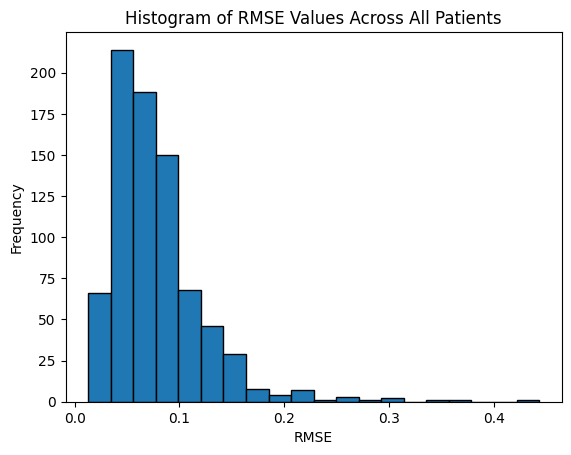

In [23]:
plt.hist(all_rmse_values, bins=20, edgecolor='black')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE Values Across All Patients')
plt.show()

#### 5.2) PERFORMANCE METRICS

In [24]:
with open('data/MLP/MLP_3predictions_by_patient.json') as json_file:
    predictions_by_patient = json.load(json_file)

In [25]:
forecast_bias_dict = {}

for key, value in predictions_by_patient.items():
    predictions = value['predictions']
    true_values = value['true_values']

    # Calculate forecast differences
    differences = [predicted - actual for predicted, actual in zip(predictions, true_values)]

    # Calculate forecast bias
    bias = sum(differences) / len(differences)
    
    forecast_bias_dict[key] = bias

In [9]:
forecast_bias_dict

{'b13fd4a3': -0.11161210899353027,
 '2cccfdd5': 0.10102162041187288,
 'e05868f8': 0.0017429026699066097,
 'ce205f7b': -0.057719081697463995,
 '081cae65': 0.15896247179985043,
 'cdefb47d': 0.08470764742851258,
 'f5005171': 0.16710046536922454,
 '0632dcdd': 0.3093795491218567,
 '350b4405': 0.08526297074317934,
 'e322be2d': -0.0666476555887858,
 '0ae92586': -0.12527413556098937,
 '6ba19c0a': 0.028085649890899657,
 '7bd82c93': 0.14362307980219524,
 '92b7f35b': -0.044670675916671745,
 '3a53eda3': 0.004769367332458507,
 'dbf50c74': 0.07918046253681184,
 '6ccb4cf6': 0.1475022499815623,
 '3bd4512f': 0.005915660715103144,
 '16bece6d': 0.2518992730140686,
 'b969f878': 0.09284165201187133,
 '7d514c28': 0.03141108281135559,
 'cc767acb': 0.09940507447242738,
 'c6df12b1': 0.11369114294052123,
 '0942aad8': 0.08098327326774597,
 'cd548f98': -0.11501616978168487,
 'e75aafae': 0.029116340721448274,
 '84074188': -0.002727696852684025,
 '1960b085': -0.007006832246780387,
 '45c64f3f': -0.03386451578140261,

In [26]:
# FORECAST BIAS SUMMARY STATISTICS
all_forecast_values = []
for value in forecast_bias_dict.values():
    if not np.isnan(value):
        all_forecast_values.append(value)

all_forecast_values = np.array(all_forecast_values)

mean_fc = np.mean(all_forecast_values)
median_fc = np.median(all_forecast_values)
std_fc = np.std(all_forecast_values)

print(f"Mean forecast bias: {mean_fc:.4f}")
print(f"Median forecast bias: {median_fc:.4f}")
print(f"Standard Deviation of forecast bias: {std_fc:.4f}")


Mean forecast bias: -0.0064
Median forecast bias: -0.0044
Standard Deviation of forecast bias: 0.0373


This shows a bias in understimating the performance of the patient

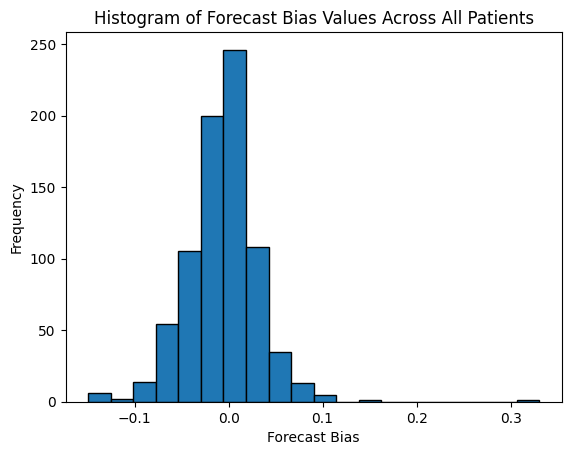

In [27]:
plt.hist(all_forecast_values, bins=20, edgecolor='black')
plt.xlabel('Forecast Bias')
plt.ylabel('Frequency')
plt.title('Histogram of Forecast Bias Values Across All Patients')
plt.show()

In [28]:
# FORECAST INTERVAL COVERAGE
def calculate_coverage(predictions_dict):
    # Dictionary to store FIC for each patient
    fic_dict = {}

    # Calculate FIC for each patient
    for key, value in predictions_dict.items():
        predictions = value['predictions']
        true_values = value['true_values']

        # Assuming you have a function to generate forecast intervals based on predictions
        forecasted_intervals = generate_forecast_intervals(predictions)

        # Calculate FIC for the current patient
        fic = calculate_coverage_for_patient(forecasted_intervals, true_values)
        
        # Store FIC in the dictionary
        fic_dict[key] = fic

    return fic_dict

def calculate_coverage_for_patient(forecasted_intervals, actual_values):
    # Calculate the number of actual values that fall within the intervals
    num_within_interval = sum((lower <= actual <= upper) for actual, (lower, upper) in zip(actual_values, forecasted_intervals))

    # Calculate the total number of observations
    total_observations = len(actual_values)

    # Calculate the coverage or FIC by dividing both values
    fic = num_within_interval / total_observations * 100

    return fic

def generate_forecast_intervals(predictions):
    # Check if predictions is a list of floats
    if all(isinstance(x, (int, float)) for x in predictions):
        return [(prediction - 0.1, prediction + 0.1) for prediction in predictions]
    # Check if predictions is a list of lists
    elif all(isinstance(x, list) and len(x) > 0 and isinstance(x[0], (int, float)) for x in predictions):
        return [(prediction[0] - 0.1, prediction[0] + 0.1) for prediction in predictions]
    else:
        raise ValueError("Predictions must be a list of floats or a list of lists with numeric values")

# Calculate FIC for each patient
fic_dict = calculate_coverage(predictions_by_patient)


In [29]:
# FIC SUMMARY STATISTICS
all_fic_values = np.array(list(fic_dict.values()))

mean_fic = np.mean(all_fic_values)
median_fic = np.median(all_fic_values)
std_fic = np.std(all_fic_values)

print(f"Mean FIC: {mean_fic:.4f}")
print(f"Median FIC: {median_fic:.4f}")
print(f"Standard Deviation of FIC: {std_fic:.4f}")

Mean FIC: 81.8481
Median FIC: 90.0000
Standard Deviation of FIC: 18.1450


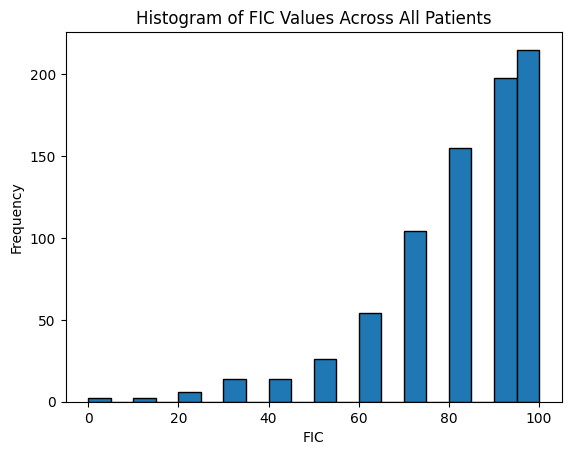

In [30]:
plt.hist(all_fic_values, bins=20, edgecolor='black')
plt.xlabel('FIC')
plt.ylabel('Frequency')
plt.title('Histogram of FIC Values Across All Patients')
plt.show()

In [31]:
# PREDICTION DIRECTION ACCURACY
def calculate_pda(predictions_dict):
    # Initialize the value of the correct directions variable
    correct_directions_total = 0
    total_directions = 0

    # Iterate through each patient in the dictionary
    for key, values in predictions_dict.items():
        # Extract predicted and true values
        predicted_values = values['predictions']
        actual_values = values['true_values']

        # Iterate each value
        for i in range(1, len(predicted_values)):
            # Calculate predicted and actual directions
            pred_change = predicted_values[i] - predicted_values[i - 1]
            actual_change = actual_values[i] - actual_values[i - 1]

            # Check if the predictions match the actual directions
            if (pred_change > 0 and actual_change > 0) or (pred_change < 0 and actual_change < 0):
                correct_directions_total += 1

            total_directions += 1

    # Calculate PDA
    pda = (correct_directions_total / total_directions) * 100
    return pda

# Calculate PDA for your dictionary
pda = calculate_pda(predictions_by_patient)
print("Prediction Direction Accuracy:", pda, '%')

Prediction Direction Accuracy: 81.99718706047821 %


## 6) PREDICTION VS TRUE VALUE PLOTS

In [32]:
filtered_rmse_dict = [key for key, values in predictions_by_patient.items() if len(values['predictions']) > 5]

In [33]:
# Get patients with more than 5 values in 'predictions'
keys_with_more_than_5_values = [key for key, values in predictions_by_patient.items() if len(values['predictions']) > 5]

# Filter rmse_dict based on the keys with more than 5 values
filtered_rmse_dict = {key: rmse_dict[key] for key in keys_with_more_than_5_values}

# Calculate the mean of means
mean_of_means = sum(rmse_dict.values()) / len(rmse_dict)

# Set a threshold for selecting keys with mean RMSE values close to the mean of means
threshold = 0.01  # Adjust this threshold as needed

# Get 4-5 keys with the maximum mean RMSE values
max_keys = sorted(filtered_rmse_dict, key=filtered_rmse_dict.get, reverse=True)[:5]

# Get 4-5 keys with the mean RMSE values close to the mean of means
average_keys = [patient_id for patient_id, mean_rmse in filtered_rmse_dict.items() if abs(mean_rmse - mean_of_means) <= threshold][:5]

# Get 4-5 keys with the minimum mean RMSE values
min_keys = sorted(filtered_rmse_dict, key=filtered_rmse_dict.get)[:5]

# Print the results
print("Keys with Maximum Mean RMSE Values:", max_keys)
print("Keys with Mean RMSE Values Close to the Mean of Means:", average_keys)
print("Keys with Minimum Mean RMSE Values:", min_keys)


Keys with Maximum Mean RMSE Values: ['f44bab4a', '7bc6e27d', '3067d328', '0b95ac27', '57ecd914']
Keys with Mean RMSE Values Close to the Mean of Means: ['bed89b83', '42bac1f0', 'ce901228', '7c2f6854', 'd0dd067e']
Keys with Minimum Mean RMSE Values: ['3b251b28', '3d2fafd5', 'e5cb2f5e', '151f785d', '76538b22']


In [34]:
dfs = {}  # Dictionary to store dataframes with patient_id as key

for patient_id in max_keys:
    if patient_id in predictions_by_patient:
        # Extract predictions and true_values from pred_dictionary
        predictions = predictions_by_patient[patient_id]['predictions']
        true_values = predictions_by_patient[patient_id]['true_values']

        # Create a dataframe for each patient
        df_patient = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

        # Save the dataframe with patient_id as key
        dfs[patient_id] = df_patient

for patient_id in min_keys:
    if patient_id in predictions_by_patient:
        # Extract predictions and true_values from pred_dictionary
        predictions = predictions_by_patient[patient_id]['predictions']
        true_values = predictions_by_patient[patient_id]['true_values']

        # Create a dataframe for each patient
        df_patient = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

        # Save the dataframe with patient_id as key
        dfs[patient_id] = df_patient

for patient_id in average_keys:
    if patient_id in predictions_by_patient:
        # Extract predictions and true_values from pred_dictionary
        predictions = predictions_by_patient[patient_id]['predictions']
        true_values = predictions_by_patient[patient_id]['true_values']

        # Create a dataframe for each patient
        df_patient = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

        # Save the dataframe with patient_id as key
        dfs[patient_id] = df_patient

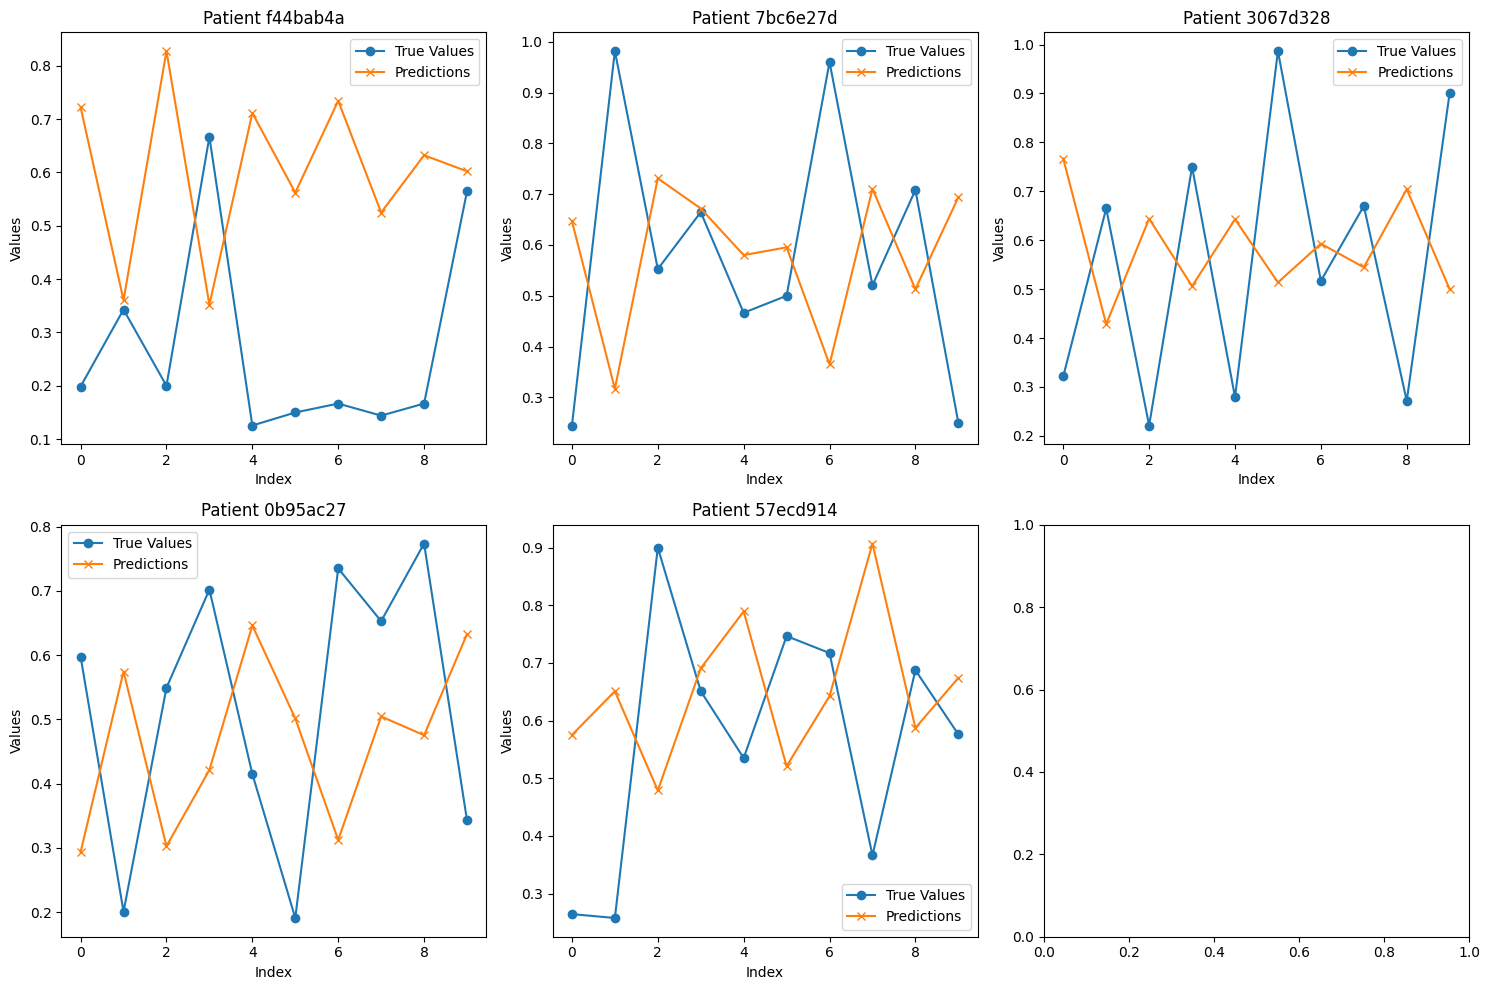

In [35]:
# PATIENTS WITH MAXIMUM RMSE VALUES

selected_dfs = {patient_id: dfs[patient_id] for patient_id in max_keys}

#  Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the 2D array of subplots to make it easier to iterate
axes = axes.flatten()

# Iterate over the selected dataframes and plot predictions vs true_values
for i, (patient_id, df) in enumerate(selected_dfs.items()):
    ax = axes[i]
    ax.plot(df['True_Values'], label='True Values', marker='o')
    ax.plot(df['Predictions'].explode(), label='Predictions', marker='x')  # Flatten the lists using explode
    ax.set_title(f'Patient {patient_id}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

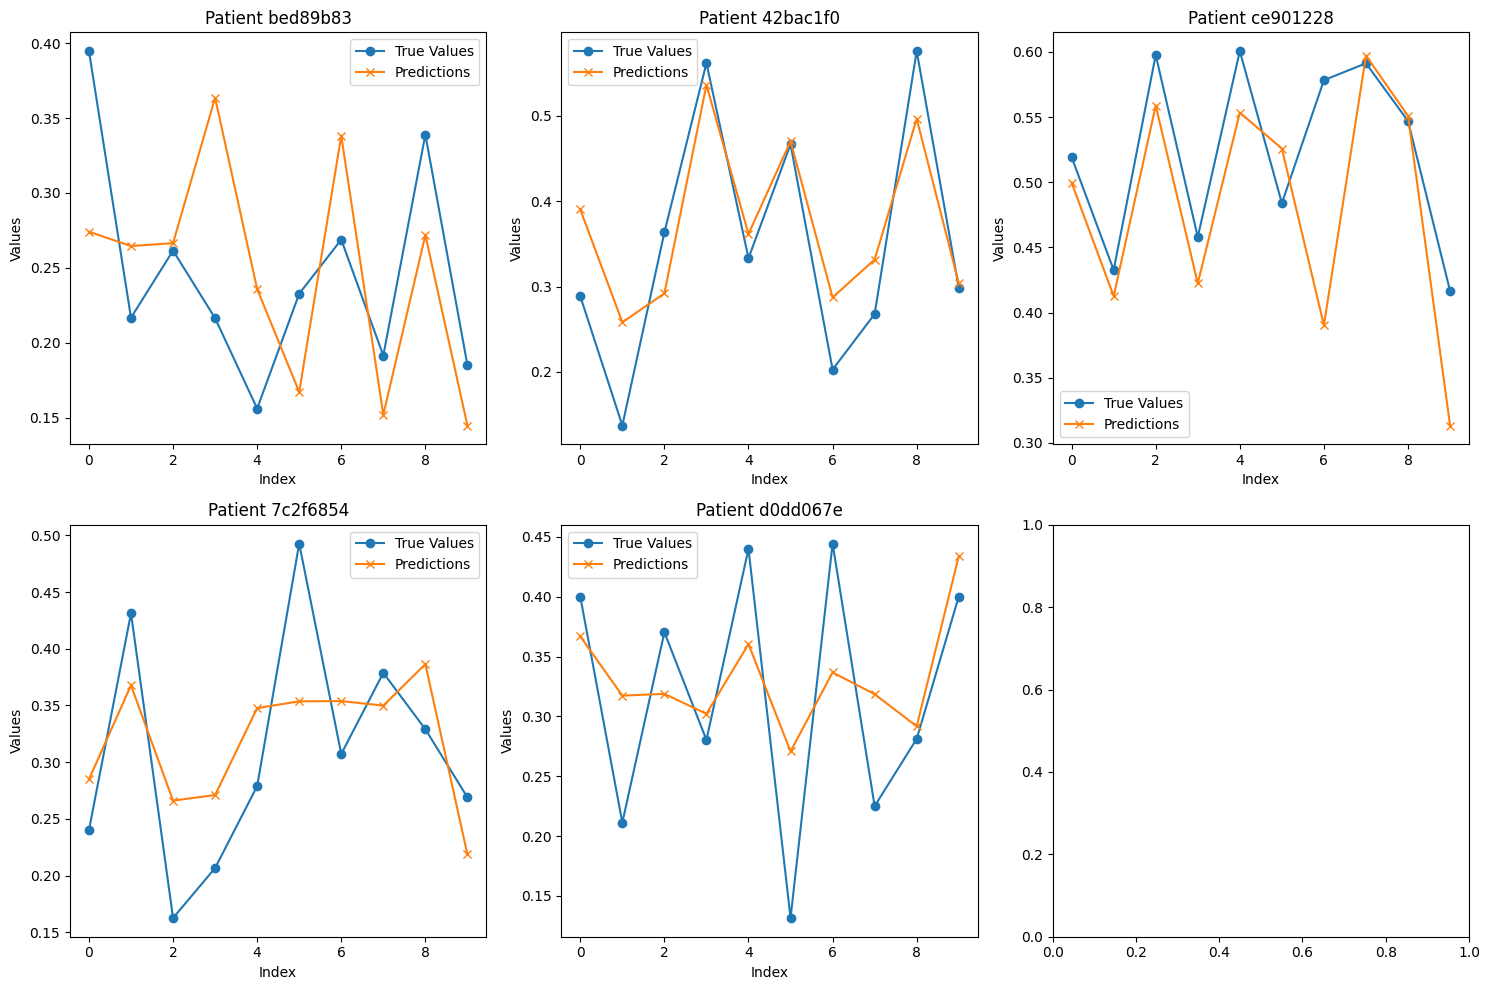

In [36]:
# PATIENTS WITH AVERAGE RMSE VALUES

selected_dfs = {patient_id: dfs[patient_id] for patient_id in average_keys}

#  Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the 2D array of subplots to make it easier to iterate
axes = axes.flatten()

# Iterate over the selected dataframes and plot predictions vs true_values
for i, (patient_id, df) in enumerate(selected_dfs.items()):
    ax = axes[i]
    ax.plot(df['True_Values'], label='True Values', marker='o')
    ax.plot(df['Predictions'].explode(), label='Predictions', marker='x')  # Flatten the lists using explode
    ax.set_title(f'Patient {patient_id}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

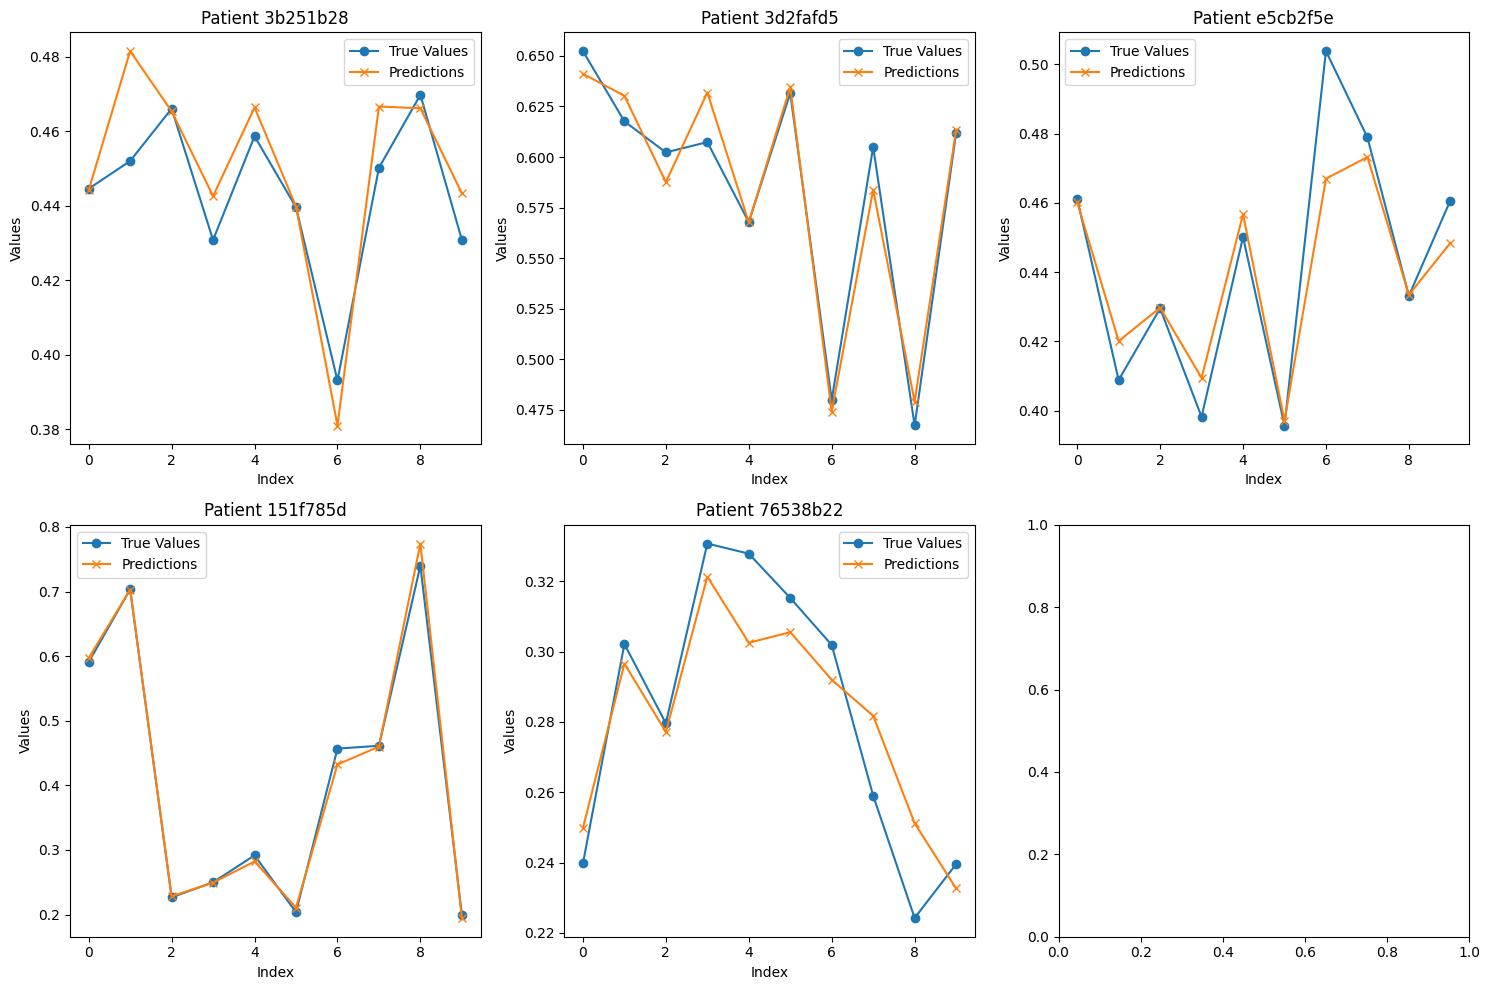

In [37]:
# PATIENTS WITH LOWEST RMSE VALUES

selected_dfs = {patient_id: dfs[patient_id] for patient_id in min_keys}

#  Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the 2D array of subplots to make it easier to iterate
axes = axes.flatten()

# Iterate over the selected dataframes and plot predictions vs true_values
for i, (patient_id, df) in enumerate(selected_dfs.items()):
    ax = axes[i]
    ax.plot(df['True_Values'], label='True Values', marker='o')
    ax.plot(df['Predictions'].explode(), label='Predictions', marker='x')  # Flatten the lists using explode
    ax.set_title(f'Patient {patient_id}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## 7) RMSE PLOTS

    Patient      RMSE
0  b13fd4a3  0.189626
1  2cccfdd5  0.332660
2  e05868f8  0.274371
3  ce205f7b  0.175740
4  081cae65  0.206467


<Figure size 1600x600 with 0 Axes>

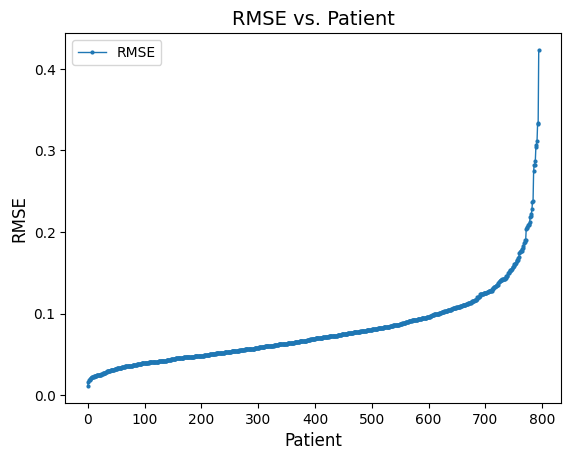

In [3]:
with open('data/MLP/MLP_1RMSE_predictions.json') as json_file:
    rmse_dict1 = json.load(json_file)

import matplotlib.pyplot as plt
# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict1.items()]

# Create DataFrame from the list of tuples
df1 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

# Show the first few rows of the DataFrame
print(df1.head())

df1= df1.sort_values(by="RMSE")
# df1["log"] = np.log(df1['RMSE'])
df1.reset_index(drop=True, inplace=True)

# Set figure size with increased width
plt.figure(figsize=(16, 6))  # Adjust the width (16) as needed

# Plot the DataFrame with reduced marker size and line width
df1.plot(y='RMSE', kind='line', marker='o', linestyle='-', markersize=2, linewidth=1)

# Add title and labels with reduced font size
plt.title('RMSE vs. Patient', fontsize=14)
plt.xlabel('Patient', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Optionally, adjust other plot parameters such as grid, legend, etc.

# Show plot
plt.show()

<Figure size 1600x600 with 0 Axes>

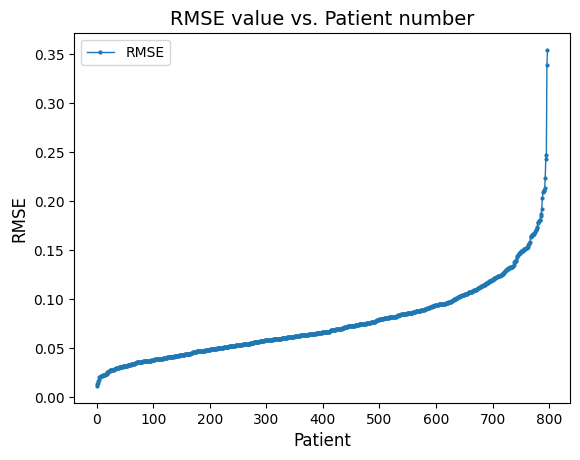

In [4]:
with open('data/MLP/MLP_2RMSE_predictions.json') as json_file:
    rmse_dict2 = json.load(json_file)

# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict2.items()]

# Create DataFrame from the list of tuples
df2 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

# Show the first few rows of the DataFrame
# print(df1.head())

df2= df2.sort_values(by="RMSE")
df2.reset_index(drop=True, inplace=True)

# df2["log"] = np.log(df2['RMSE'])

# Set figure size with increased width
plt.figure(figsize=(16, 6))  # Adjust the width (16) as needed

# Plot the DataFrame with reduced marker size and line width
df2.plot(y='RMSE', kind='line', marker='o', linestyle='-', markersize=2, linewidth=1)

# Add title and labels with reduced font size
plt.title('RMSE value vs. Patient number', fontsize=14)
plt.xlabel('Patient', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Optionally, adjust other plot parameters such as grid, legend, etc.

# Show plot
plt.show()

<Figure size 1600x600 with 0 Axes>

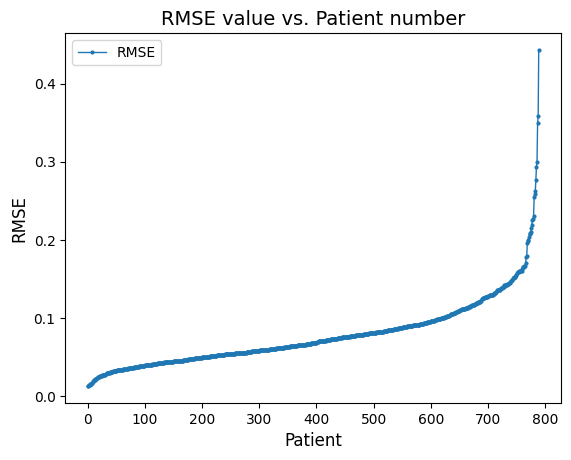

In [5]:
with open('data/MLP/MLP_3RMSE_predictions.json') as json_file:
    rmse_dict3 = json.load(json_file)

# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict3.items()]

# Create DataFrame from the list of tuples
df3 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

# Show the first few rows of the DataFrame
# print(df1.head())

df3= df3.sort_values(by="RMSE")
df3.reset_index(drop=True, inplace=True)

# df3["log"] = np.log(df3['RMSE'])

# Set figure size with increased width
plt.figure(figsize=(16, 6))  # Adjust the width (16) as needed

# Plot the DataFrame with reduced marker size and line width
df3.plot(y='RMSE', kind='line', marker='o', linestyle='-', markersize=2, linewidth=1)

# Add title and labels with reduced font size
plt.title('RMSE value vs. Patient number', fontsize=14)
plt.xlabel('Patient', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Optionally, adjust other plot parameters such as grid, legend, etc.

# Show plot
plt.show()

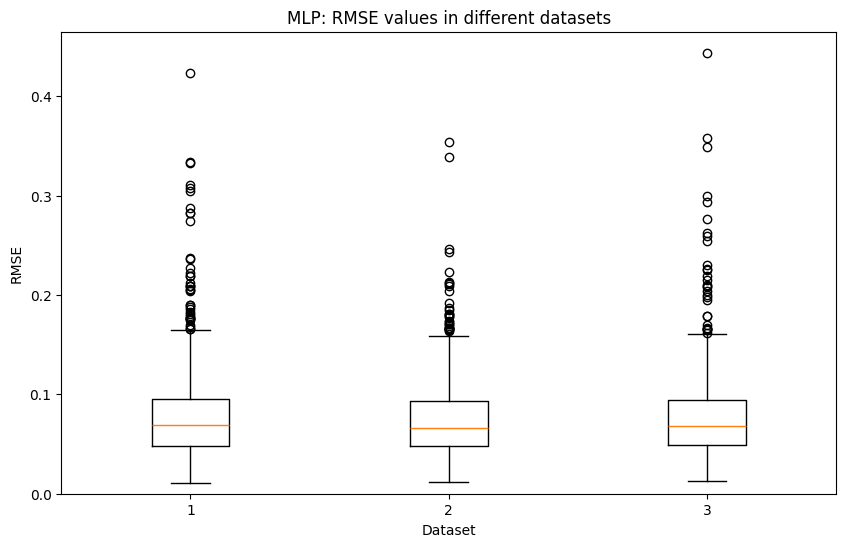

<Figure size 640x480 with 0 Axes>

In [13]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot box plots for df1, df2, and df3
plt.boxplot([df1['RMSE'], df2['RMSE'], df3['RMSE']], labels=['1', '2', '3'])

# Add title and labels
plt.title('MLP: RMSE values in different datasets')
plt.xlabel('Dataset')
plt.ylabel('RMSE')

# Set y-axis starting at 0
plt.ylim(0)

# Show plot
plt.show()

# plt.savefig('Boxplot_MLP_RMSE.png')

#### 7.1) BETWEEN MODEL RMSE

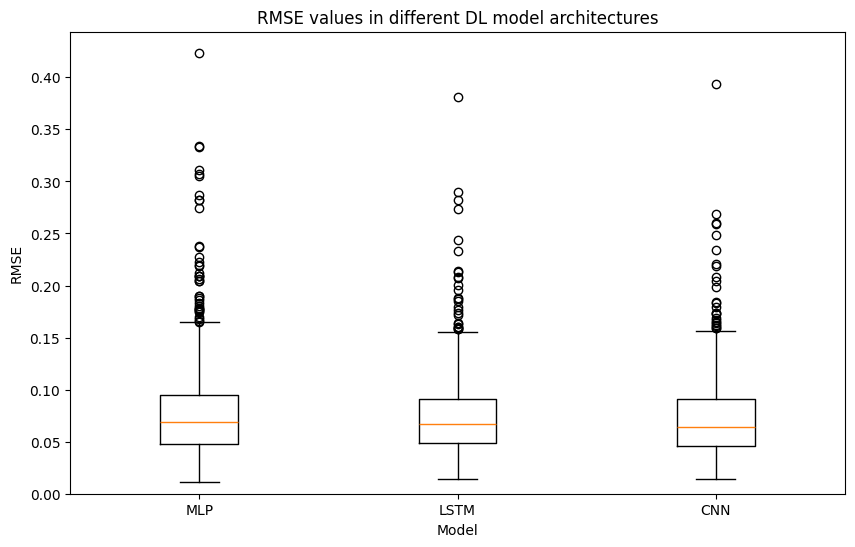

<Figure size 640x480 with 0 Axes>

In [17]:
with open('data/MLP/MLP_1RMSE_predictions.json') as json_file:
    rmse_dict1 = json.load(json_file)

# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict1.items()]

# Create DataFrame from the list of tuples
df1 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

#############################################
with open('data/LSTM/LSTM_1RMSE_predictions.json') as json_file:
    rmse_dict1 = json.load(json_file)

import matplotlib.pyplot as plt
# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict1.items()]

# Create DataFrame from the list of tuples
df2 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

############################################
with open('data/CNN/CNN_1RMSE_predictions.json') as json_file:
    rmse_dict1 = json.load(json_file)

# Assuming rmse_dict is your dictionary containing data
# Convert dictionary to list of tuples
data_list = [(key, value) for key, value in rmse_dict1.items()]

# Create DataFrame from the list of tuples
df3 = pd.DataFrame(data_list, columns=['Patient', 'RMSE'])

# Set figure size
plt.figure(figsize=(10, 6))

# Plot box plots for df1, df2, and df3
plt.boxplot([df1['RMSE'], df2['RMSE'], df3['RMSE']], labels=['MLP', 'LSTM', 'CNN'])

# Add title and labels
plt.title('RMSE values in different DL model architectures')
plt.xlabel('Model')
plt.ylabel('RMSE')

# Set y-axis starting at 0
plt.ylim(0)

# Show plot
plt.show()

# plt.savefig('Boxplot_models_RMSE.png')
